# Liouvillian learning from generalized energy conservation

This notebook demonstrates Hamiltonian and Liouvillian learning from generalized energy conservation as introduced in Olsacher et al. *Hamiltonian and Liouvillian learning in weakly-dissipative quantum many-body systems* (2025).
We are going to learn the Hamiltonian and dissipation rates of a mock experiment using different parametrizations.

The full master equation for a density matrix $\rho$ reads
$$
\frac{d\rho}{dt}
=
-i[H,\rho]
+
\sum_{j=1}^N \gamma_j
\left(
\sigma_j^- \rho \sigma_j^+
-
\frac{1}{2}
\left\{
\sigma_j^+ \sigma_j^-,
\rho
\right\}
\right)
$$
with Hamiltonian
$$
\hat{H} = \sum_{i=1}^{N-2} J_{xx} \sigma_i^x \sigma_{i+1}^x + \sum_{i=1}^N B_i \sigma_i^z .
$$

In [1]:
import numpy as np
from icecream import ic
import itertools as it
from matplotlib import pyplot as plt
import sys
sys.path.append("../")
from src.hamiltonian_learning import Ansatz, Constraint, get_times
from src.pauli_algebra import qop_mean, qop_var, QuantumOperator
from src.quantum_simulator import QuantumSimulator, QuantumState, get_random_product_states
from src.model_hamiltonians import get_hamiltonian, get_dissipators
from src.ansatz_parametrization import Parametrization, ParametrizationFunction
# set random seed
np.random.seed(0)

We first setup a quantum simulator that serves as our mock experiment.

In [2]:
### STEP 1 ### define model and quantum simulator

# system parameters
Nqubits = 4

# nearest-neighbor XX coupling
Jxx_coupling = 10
Jxx = Jxx_coupling * (np.diag(np.ones(Nqubits - 1), 1) + np.diag(np.ones(Nqubits - 1), -1))

# magnetic field in Z direction
Bz_field = 10
Bz = Bz_field * np.ones(Nqubits)

# spontaneous emission dissipator rates
dissipation_rate = 0.5
dissipation_rates = dissipation_rate * np.eye(Nqubits)

# construct the Hamiltonian
hamiltonian_terms = {"Jxx": Jxx, "Bz": Bz}
Hsim = get_hamiltonian(Nqubits, terms=hamiltonian_terms).remove_zero_coeffs()

# construct dissipators
dissipator_rates = {"Gm": dissipation_rates}
Dsim = get_dissipators(Nqubits, dissipation_rates=dissipator_rates)

## setup quantum simulator
qsim = QuantumSimulator(Nions=Nqubits)
qsim.hamiltonian = Hsim.copy()        
qsim.dissipators = Dsim.copy()

Next we will setup the ansatz that we will use for Hamiltonian and Liouvillian learning.
Our goal is to learn the Hamiltonian ``operator_learned`` and the jump operators and their dissipation rates ``dissipators_learned``.
While the Hamiltonian parameters are learned from solving a linear equation, some learning methods learn the dissipation rates using nonlinear optimization which require bounds.
Errorbars for the learned parameters are estimated via bootstrapping of the rows of the constraint matrix. Here ``ansatz.n_resampling_constaints[0]`` is the ratio of rows excluded and ``ansatz.n_resampling_constaints[1]`` is the number of samples taken. We sample rows with replacement.



In [3]:
### STEP 2 ### setup ansatz for learning

# setup ansatz Hamiltonian and dissipators
ansatz = Ansatz(Nions=Nqubits)
ansatz.ansatz_operator = Hsim.copy()
ansatz.ansatz_dissipators = Dsim.copy()

# setup bounds and guess for the dissipation rates
Dbounds = [(0,2*dissipation_rate) for _ in range(Nqubits)]
ansatz.gamma_bounds = Dbounds
ansatz.gamma0 = np.array([0.5*dissipation_rate for _ in range(Nqubits)])

# choose how to resample rows of constraint tensors when estimating errorbars
ansatz.n_resampling_constraints = (0, 20)
ansatz.resampling_constraints_replace = True

# setup the values that should be calculated
ansatz.result_keys = ["operator_learned", "dissipators_learned"]



Learning can be performed using a parametrization of the ansatz. A parametrization can be used to exclude specific terms from the ansatz. Or to introduce dependencies between different ansatz terms.
Below we introduce 2 different parametrizations:
    - a "free" parametrization for the Hamiltonian alone that excludes the dissipation rates.
    - a parametrization with translational invariant magnetic field and translational invariant dissipation.

In [4]:
### STEP 3 ### setup parametrizations for learning

parametrizations = []

### free parametrization without dissipation
par = Parametrization()
par.name = "free"
# add parametrization functions for all terms in the Hamiltonian
par.add_functions_for_free_terms(Hsim)
parametrizations.append(par)

### free parametrization with translational invariant dissipation
par_diss = Parametrization()
par_diss.name = "tran. inv."
# translational invariant Z field
parfct_Zconst = ParametrizationFunction(criterion="Z", param_type="translational_symmetry")    
par_diss.add_functions([parfct_Zconst])
# add all remaining ansatz terms
par_diss.add_functions_for_free_terms(Hsim)
# add translational invariant dissipation
parfct_diss = ParametrizationFunction(criterion=["M","M"], param_type="translational_symmetry", range=0, coherent=False)
par_diss.add_functions([parfct_diss])
parametrizations.append(par_diss)

Next we set up the constraints that will be measured to learn the ansatz coefficients. 
The constraints required depend on the learning method that is used.
Here we use the O3KZ method introduced in Olsacher et al. 2025.

In [5]:
### STEP 4 ### setup constraints for learning from random time-traces

## set initial states for learning
number_of_initial_states = 10
states_learn = get_random_product_states(Nqubits, number_of_initial_states, chosen_bases=["x", "z"])

## set all times that will be simulated 
total_time = 0.05 # total time 
ntimesteps = 10 # integral discretization steps
alltimes = np.linspace(0, total_time, ntimesteps)

## set timespans that will be used for learning
ntimes = 2 # number of different time constraints
times_learn = get_times(alltimes, ntimesteps, ntimes)

## generate the constraints for learning
constraints = [Constraint(initial_state=tmp[0], simulation_times=tmp[1], constraint_operator=None) for tmp in it.product(states_learn, times_learn)]

Now we run our mock experiment in order to generate the measurement data required for learning using the given constraints.
The .get_data() method automatically determines a set of measurement settings that must be executed on the quantum simulator. 
Note that this set is not always optimal/minimal. It often helps to pass a list of suggested measurement basis.

In [6]:
### STEP 5 ### generate measurement data for the constraints

Gaussian_noise = False
suggested_measurement_bases = ["X"*Nqubits,"Y"*Nqubits,"Z"*Nqubits] 
# nshots_list = [10000]
nshots_max = 2000 #max(nshots_list)
if Gaussian_noise:
    nshots_max = 0
ansatz.get_data(qsim, method="O3KZi", constraints=constraints, nshots=nshots_max, suggested_measurement_bases=suggested_measurement_bases)

# count total number of measurements taken
nshots_total = ansatz.data_set.get_nruns()

ic| pstr_get_data: 'took 0.027907133102416992 seconds to simulate the first state out of 9'


We plot an example time-trace to check if there are enough time-steps points for numerical integration over time, as is required for learning.

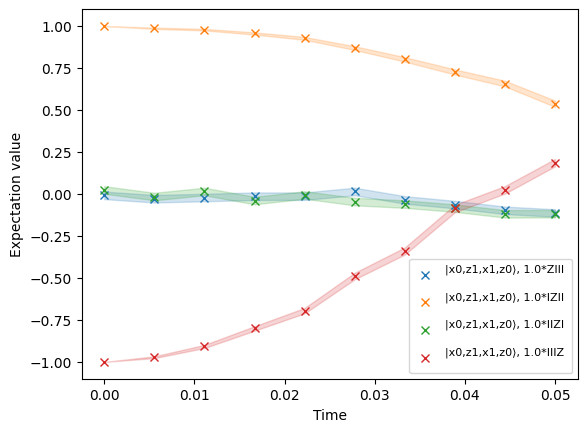

(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Expectation value'>)

In [7]:
### STEP 6 ### check time dynamics of observables from data set

qops = [QuantumOperator(N=Nqubits, terms={"ZIII":1.0}), QuantumOperator(N=Nqubits, terms={"IZII":1.0}), QuantumOperator(N=Nqubits, terms={"IIZI":1.0}), QuantumOperator(N=Nqubits, terms={"IIIZ":1.0})]
ansatz.data_set.plot_time_dynamics(observables=qops, nshots=-1, errorbars=True, states=[states_learn[0]])

Next we calculate the constraint tensors from the data.

In [8]:
### STEP 7 ### calculate the constraint tensors for learning

# construct the constraint tensors for learning
ansatz.get_constraint_tensors(constraints=constraints, label="learn", method="O3KZi", nshots=-1, Gaussian_noise=Gaussian_noise)

# check the constructed constraint tensors
ic(ansatz.constraint_tensors.keys())

ic| ansatz.constraint_tensors.keys(): dict_keys([('learn', 'O3KZi', -1)])


dict_keys([('learn', 'O3KZi', -1)])

Finally we perform the learning for all parametrizations and different number of measurements used.
We then extract the results from the ansatz.result attribute.

In [ ]:
### STEP 8 ### learn the ansatz coefficients and extract results

### learn the Hamiltonian and dissipators
ansatz.learn(learn_method="O3KZi", nshots=-1, parametrizations=parametrizations)

# check the result keys
ic(ansatz.result.keys())

### extract the results
# learned Hamiltonian (normalized)
ansatz.plotdata["Hlearn"] = [qop_mean([abs(learnop) for learnop in ansatz.result[("O3KZi",-1)].operator_learned[parinx]]) for parinx in range(len(parametrizations))]
ansatz.plotdata["var_Hlearn"] = [qop_var([abs(learnop) for learnop in ansatz.result[("O3KZi",-1)].operator_learned[parinx]]) for parinx in range(len(parametrizations))]
# learned dissipators
if ansatz.ansatz_dissipators is not None:
    ansatz.plotdata["Dlearn"] = [np.mean([[diss.coeff for diss in diss_samp] for diss_samp in ansatz.result[("O3KZi",-1)].dissipators_learned[parinx]],axis=0) for parinx in range(len(parametrizations))]  
    ansatz.plotdata["var_Dlearn"] = [np.var([[diss.coeff for diss in diss_samp] for diss_samp in ansatz.result[("O3KZi",-1)].dissipators_learned[parinx]],axis=0) for parinx in range(len(parametrizations))]

ic| pstr_learn: 'enter learn method O3KZi with nshots -1 and 1 cpus'
ic| pstr_resampling: 'number of samples taken for errorbars is 20'
Processing samples for errorbars: 100%|██████████| 20/20 [00:00<00:00, 50.71it/s]


We plot the learned parameters against the simulated parameters. Note that the parameters are only learned up to an undetermined overall scale. 
This scale can be constructed separately using additional constraints from another learning method that we introduce in the 02-learning-from-time-traces.ipynb notebook.

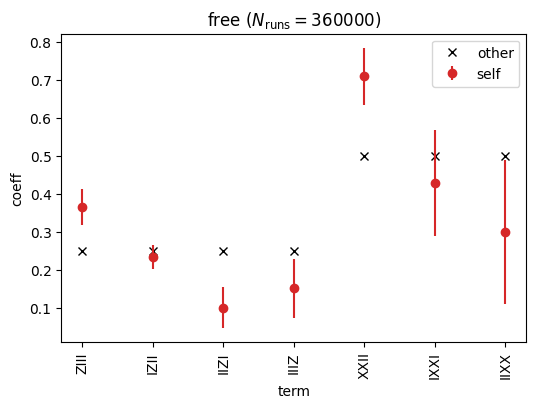

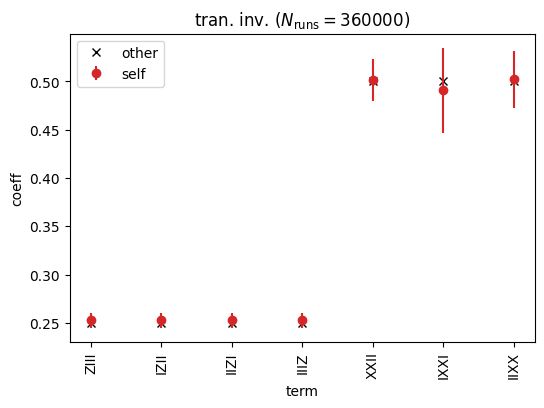

In [10]:
### STEP 9 ### plot the learned Hamiltonian (normalized)

tmp_parinx_list_plot = list(range(len(parametrizations)))
tardiss = [diss.coeff for diss in Dsim]

### plot learned Hamiltonian
for parinxinx, parinx in enumerate(tmp_parinx_list_plot):
    tmpop = ansatz.plotdata["Hlearn"][parinx].remove_zero_coeffs()
    var_tmpop = ansatz.plotdata["var_Hlearn"][parinx]
    tmpdiss = None
    var_tmpdiss = None
    if ansatz.ansatz_dissipators is not None:
        tmpdiss = ansatz.plotdata["Dlearn"][parinx]
        var_tmpdiss = ansatz.plotdata["var_Dlearn"][parinx]
    plotlabel = r"{} ($N_\mathrm{{runs}}={})$".format(parametrizations[parinx].name, nshots_total)
    tmpop.plot(var=var_tmpop, other=Hsim, add_labels=True, normalize=True, title=plotlabel) #, dissrates=tmpdiss, var_dissrates=var_tmpdiss, other_dissrates=tardiss)

We also plot the learned dissipation rates. Note that those are learned including their norm in contrast to the Hamiltonian parameters.

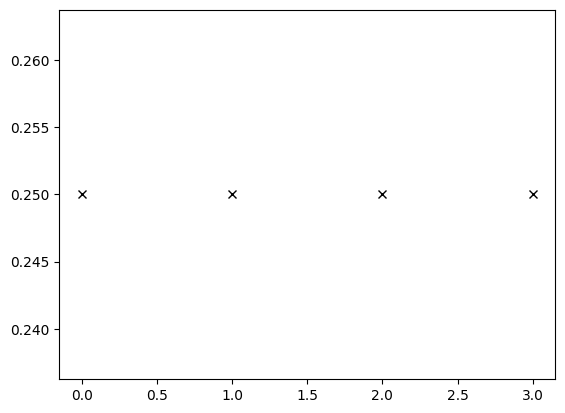

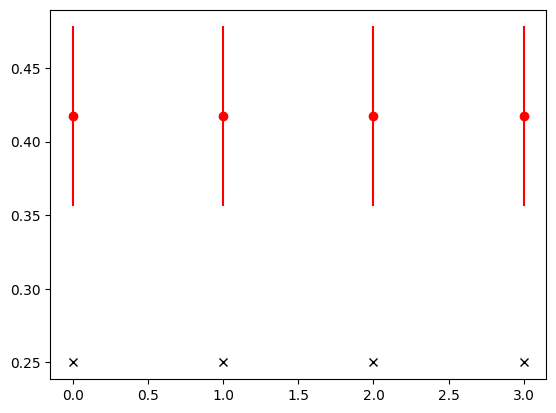

In [11]:
### STEP 10 ### plot the learned dissipation rates 

### plot learned dissipators
if ansatz.ansatz_dissipators is not None:
    for parinxinx, parinx in enumerate(tmp_parinx_list_plot):
        plt.figure()
        ydata = ansatz.plotdata["Dlearn"][parinx]
        var_ydata = ansatz.plotdata["var_Dlearn"][parinx]
        plt.errorbar(range(len(ydata)), np.abs(ydata), yerr=np.sqrt(var_ydata), linestyle="", marker="o", color="r")
        # plot target rates
        ydata_tar = np.divide([diss.coeff for diss in Dsim],2)
        plt.plot(ydata_tar, linestyle="", marker="x", color="k")